In [40]:

import gpflow
import numpy as np
import pandas as pd
import tensorflow as tf
from gpflow.base import _cast_to_dtype
from models.test_functions import TestFunLinearCorrelation
from gpflow.utilities import to_default_float, print_summary
from gpflow.config import default_float
# from gpflow.ci_utils import ci_niter
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from utils.utils import build_models, train_models, get_final_models_dict, get_gridpoints, get_nlpd, get_abs_error
from models.lvmogp import LVMOGP

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2023-06-14 15:03:26.499643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# LMC fitting and initialisation

This notebook is to demonstrate two things:
1. The correct initalisation of the LMC needs W to be set randomly and kappa initialise close to zero for it to work.
If W is not initalised randomly the model seems to always make W rank 1 which is not correct.
2. The LMC can learn the new functions with only 2 points on the functions when there isn't any noise, but when the
noise is larger, the LMC can be really wrong but also really confident with 2 data points. It does however recover the
correct function with more data.

## Create the very low noise test functions

Here we use the TestFun class to create a test function with the dimensions, latent dims, number of functions and noise
that we want. The test functions are independent draws of a GP.


In [41]:
set_seed = True
set_opt_seed = False

seed = 1

In [42]:
same_points = False
plot_figs = True

train_inducing = True
opt_seed = 3
domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
n_fun = 6
n_points = [30]*2 + [2]*4
max_points = 60
noise = 1e-6
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]


if type(n_points) is int:
    n_points = [n_points]*n_fun

# Create the Test functions
if set_seed:
    seed = seed #3 #2 #3 #5 #4 #1 #2
    np.random.seed(seed)
    tf.random.set_seed(seed)
else:
    seed = None


test_fun = TestFunLinearCorrelation(domain, seed, n_fun, observed_dims, latent_dims, max_points, noise, n_grid_points,
                                    same_points, lengthscales_x)

data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)

2023-06-14 15:03:29.017213: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now we create the test data

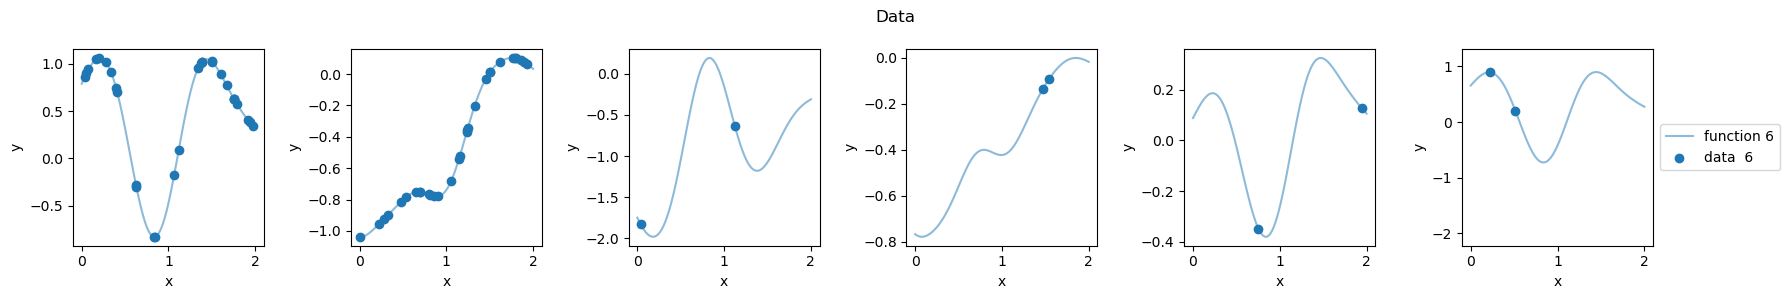

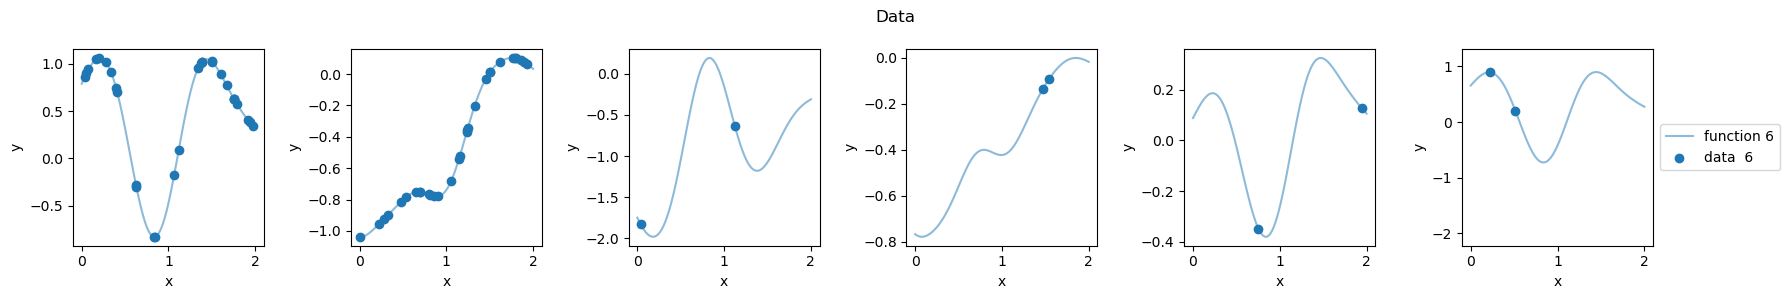

In [43]:
if plot_figs:
    test_fun.plot_data_seperate_plots()


In [44]:
x_new = np.linspace(domain[0], domain[1], 100).reshape(100, 1)
ys_new = []
for fun in test_fun.functions:
    y_new, _ = fun.predict_y(x_new)
    ys_new.append(y_new)

[Back to top](#Index:)

<a id='part1'></a>

## Part 1: very low noise and no initalisation

## Fit the LMC

With no initalisation of W or kappa.

In [45]:
lengthscales_X = [0.1, 0.1][:len(continuous_dims)]
lengthscales = lengthscales_X
X_lmc = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims ,active_dims=[observed_dims])
cov = k * coreg_k
lmc = gpflow.models.GPR(data=(tf.convert_to_tensor(X_lmc, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)


Text(0.5, 1.0, 'training curve')

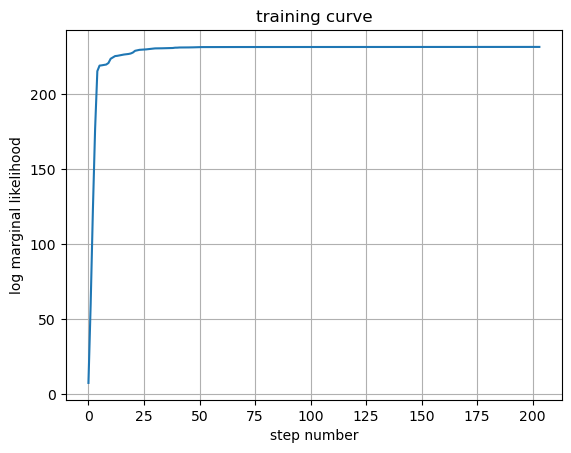

Text(0.5, 1.0, 'training curve')

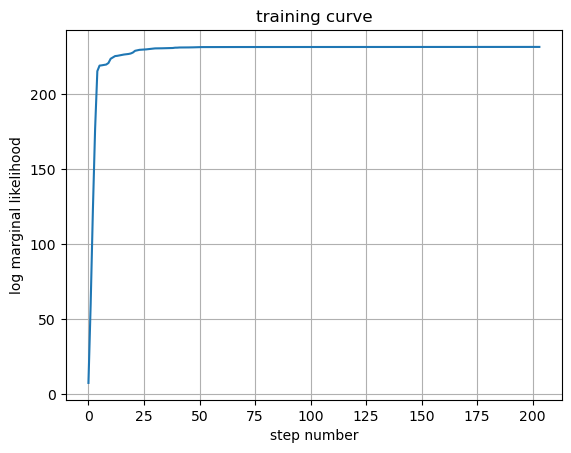

In [46]:
maxiter = 1000

lml = []
def step_callback(step, variables, values):
    lml.append(lmc.log_marginal_likelihood().numpy())
lmc_opt = gpflow.optimizers.Scipy().minimize(
    lmc.training_loss, lmc.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
    step_callback=step_callback)

plt.plot(np.arange(len(lml)), np.array(lml))
plt.grid()

plt.xlabel('step number')
plt.ylabel('log marginal likelihood')
plt.title('training curve')

In [47]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_mu, lmc_sig2 = lmc.predict_y(x_new_lmc)

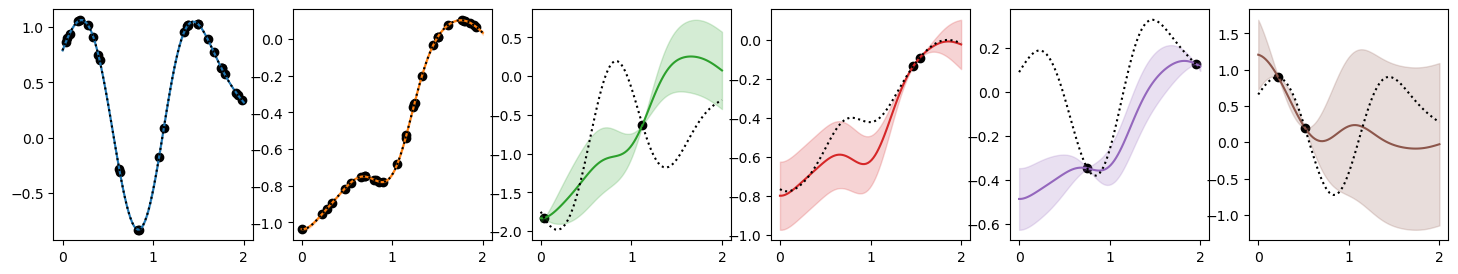

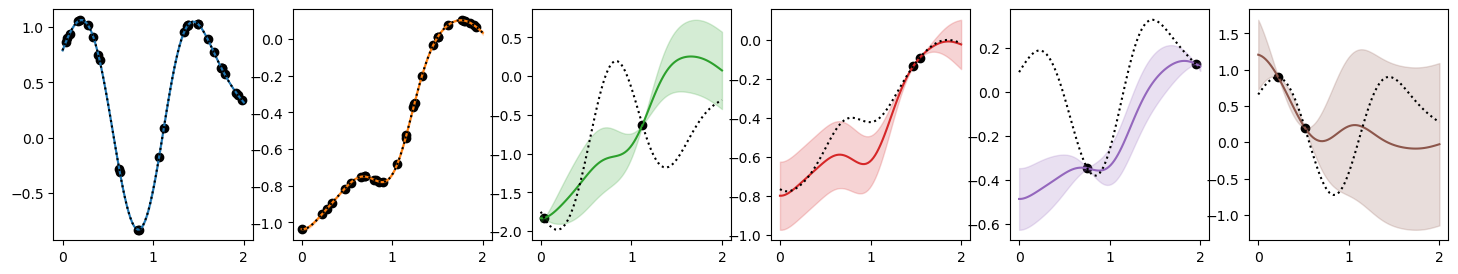

In [48]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i][:n_points[i]], test_fun.ys[i][:n_points[i]], color='k')
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_mu.numpy()[idx].flatten() + 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()),
                           lmc_mu.numpy()[idx].flatten() - 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])

The rank of W ends up being 1:

In [49]:
W_lmc = lmc.kernel.kernels[1].W.numpy()
print('rank of W:', np.linalg.matrix_rank(W_lmc))
# B2 = np.dot(W_lmc, W_lmc.T)
# print(np.linalg.matrix_rank(B2))

rank of W: 1
rank of W: 1


In [50]:
print('lmc log marginal likelihood',lmc.log_marginal_likelihood())

lmc log marginal likelihood tf.Tensor(231.4856781468672, shape=(), dtype=float64)
lmc log marginal likelihood tf.Tensor(231.4856781468672, shape=(), dtype=float64)


In [51]:
print_summary(lmc)
print(lmc.kernel.kernels[1].kappa.numpy())

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.05196                 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.37148]               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels

[Back to top](#Index:)

<a id='part2'></a>

## Part 2: very low noise and initialising W randomly and kappa to zero

In [52]:
lengthscales_X = [0.1, 0.1][:len(continuous_dims)]
lengthscales = lengthscales_X
X_lmc = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims ,active_dims=[observed_dims])
cov = k * coreg_k
lmc = gpflow.models.GPR(data=(tf.convert_to_tensor(X_lmc, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)
lmc.kernel.kernels[1].W.assign(np.random.uniform(0.1, 1, [n_fun, latent_dims]))
lmc.kernel.kernels[1].kappa.assign([1e-6]*n_fun)


<tf.Variable 'UnreadVariable' shape=(6,) dtype=float64, numpy=
array([-13.81551006, -13.81551006, -13.81551006, -13.81551006,
       -13.81551006, -13.81551006])>

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float64, numpy=
array([-13.81551006, -13.81551006, -13.81551006, -13.81551006,
       -13.81551006, -13.81551006])>

Text(0.5, 1.0, 'training curve')

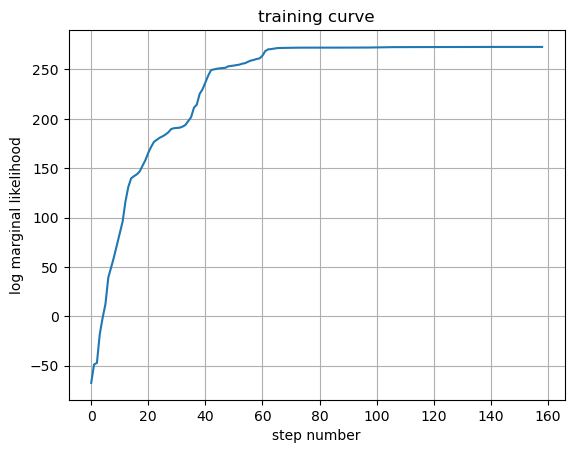

Text(0.5, 1.0, 'training curve')

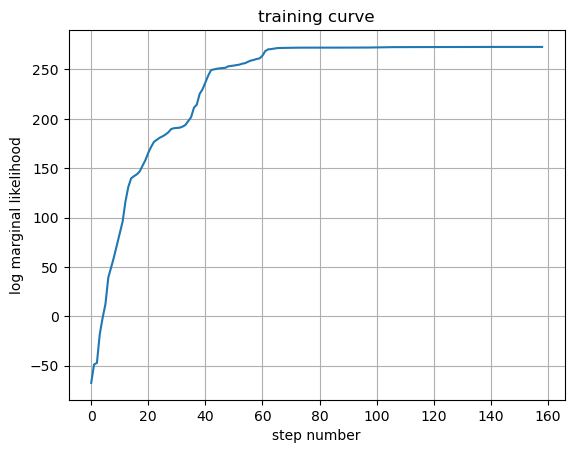

In [53]:
maxiter = 1000

lml = []
def step_callback(step, variables, values):
    lml.append(lmc.log_marginal_likelihood().numpy())
lmc_opt = gpflow.optimizers.Scipy().minimize(
    lmc.training_loss, lmc.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
    step_callback=step_callback)

plt.plot(np.arange(len(lml)), np.array(lml))
plt.grid()

plt.xlabel('step number')
plt.ylabel('log marginal likelihood')
plt.title('training curve')

In [54]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_mu, lmc_sig2 = lmc.predict_y(x_new_lmc)

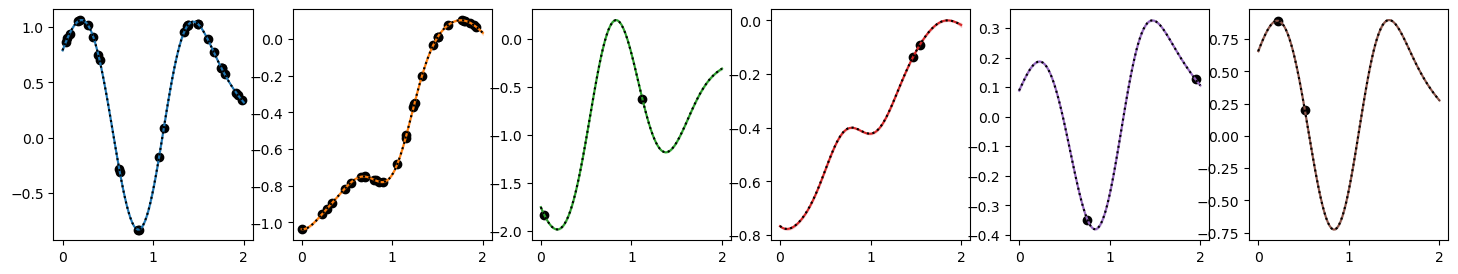

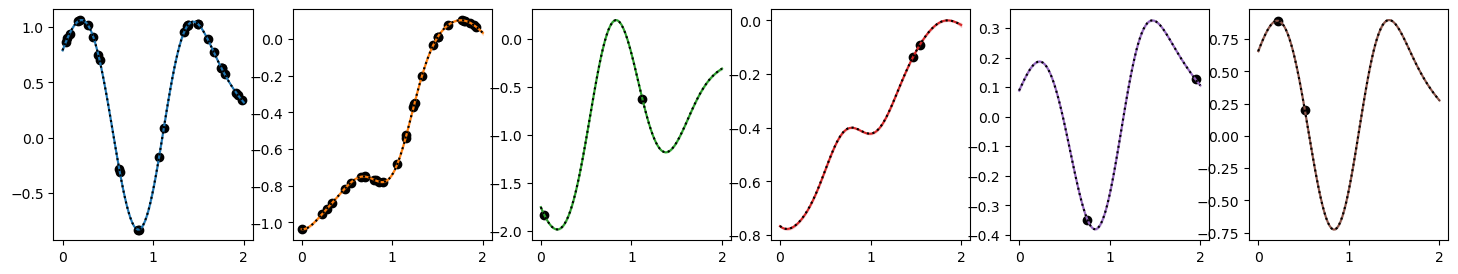

In [55]:
import pathlib as pl
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i][:n_points[i]], test_fun.ys[i][:n_points[i]], color='k')
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_mu.numpy()[idx].flatten() + 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()),
                           lmc_mu.numpy()[idx].flatten() - 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])


The rank of W ends up being 2 which is correct as there are 2 latent functions:

In [56]:
W_lmc = lmc.kernel.kernels[1].W.numpy()
print('rank of W:', np.linalg.matrix_rank(W_lmc))
# B2 = np.dot(W_lmc, W_lmc.T)
# print(np.linalg.matrix_rank(B2))

rank of W: 2
rank of W: 2


The log marginal likeihood of this model is greater than that of the previous one

In [57]:
print('lmc log marginal likelihood',lmc.log_marginal_likelihood())

lmc log marginal likelihood tf.Tensor(272.8232559472186, shape=(), dtype=float64)
lmc log marginal likelihood tf.Tensor(272.8232559472186, shape=(), dtype=float64)


In [58]:
print_summary(lmc)
print(lmc.kernel.kernels[1].kappa.numpy())

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.00278                 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.37221]               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ GPR.kernel.kernels


[Back to top](#Index:)

<a id='part3'></a>

## Part 3: noisier data and initialising W randomly and kappa to zero

In [59]:

test_fun.noise = 0.1

test_fun.ys = []
for i in range(test_fun.n_fun):
    test_fun.ys.append(test_fun.function_with_noise(test_fun.functions[i], test_fun.xs[i], noise=test_fun.noise))

data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)

Now we create the test data

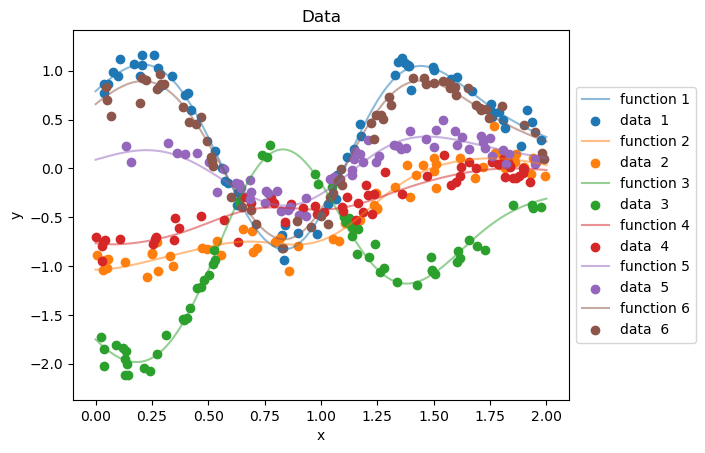

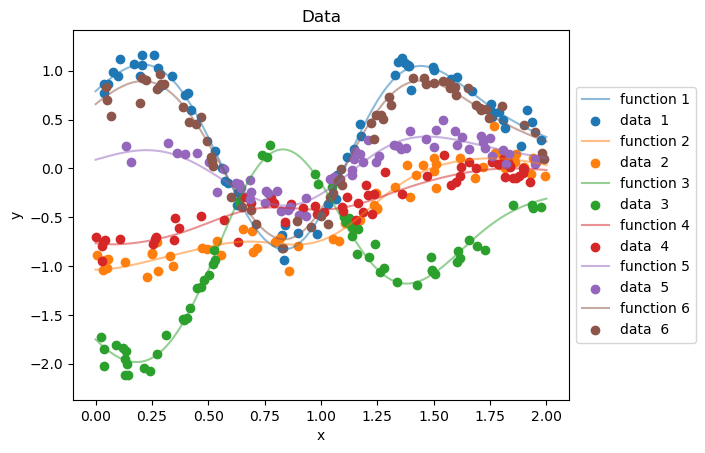

In [60]:
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)
if plot_figs:
    test_fun.plot_data()

Plot the test functions and data on seperate plots so they can be seen better. Then plot the latent coordinates
of the test functions.


In [61]:
x_new = np.linspace(domain[0], domain[1], 100).reshape(100, 1)
ys_new = []
for fun in test_fun.functions:
    y_new, _ = fun.predict_y(x_new)
    ys_new.append(y_new)


In [62]:
lengthscales_X = [0.1, 0.1][:len(continuous_dims)]
lengthscales = lengthscales_X
X_lmc = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims ,active_dims=[observed_dims])
cov = k * coreg_k
lmc = gpflow.models.GPR(data=(tf.convert_to_tensor(X_lmc, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)
lmc.kernel.kernels[1].W.assign(np.random.uniform(0.1, 1, [n_fun, latent_dims]))
lmc.kernel.kernels[1].kappa.assign([1e-6]*n_fun)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float64, numpy=
array([-13.81551006, -13.81551006, -13.81551006, -13.81551006,
       -13.81551006, -13.81551006])>

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float64, numpy=
array([-13.81551006, -13.81551006, -13.81551006, -13.81551006,
       -13.81551006, -13.81551006])>

Text(0.5, 1.0, 'training curve')

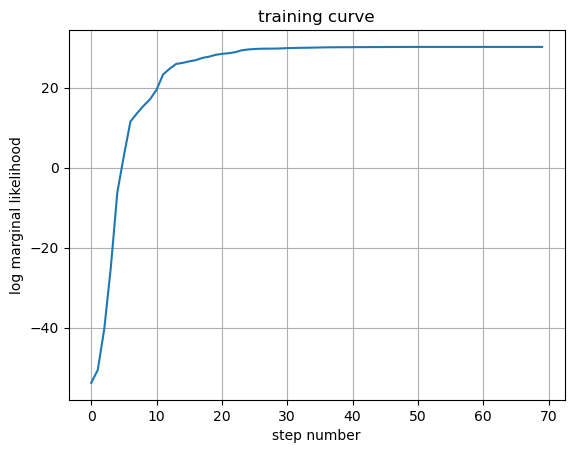

Text(0.5, 1.0, 'training curve')

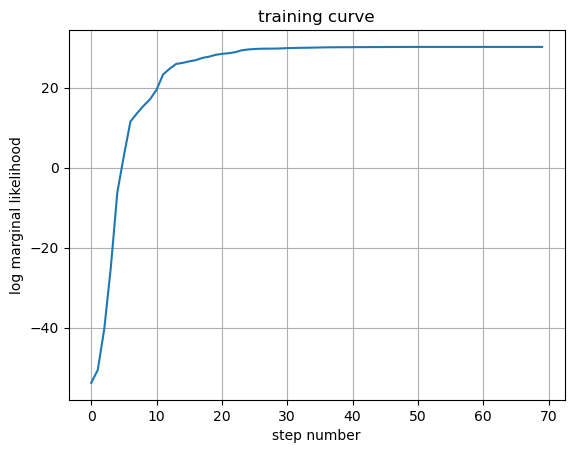

In [63]:
maxiter = 1000

lml = []
def step_callback(step, variables, values):
    lml.append(lmc.log_marginal_likelihood().numpy())
lmc_opt = gpflow.optimizers.Scipy().minimize(
    lmc.training_loss, lmc.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
    step_callback=step_callback)

plt.plot(np.arange(len(lml)), np.array(lml))
plt.grid()

plt.xlabel('step number')
plt.ylabel('log marginal likelihood')
plt.title('training curve')

In [64]:
x_new, fun_nos, x_new_lmc, x_new_lvmogp = get_gridpoints(domain, n_fun, {'lmc':lmc}, observed_dims, n_points=100)
lmc_mu, lmc_sig2 = lmc.predict_y(x_new_lmc)

We can see the model fits badly here, with some of the new functions being predicted very wrong but also very
confidently

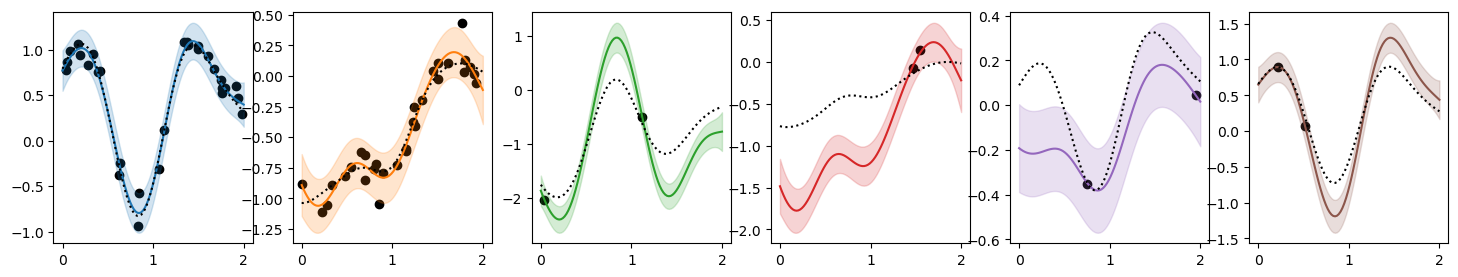

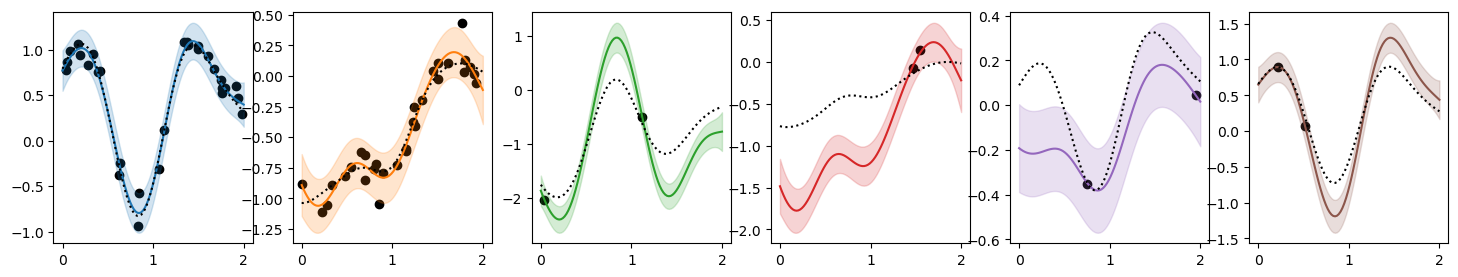

In [65]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i][:n_points[i]], test_fun.ys[i][:n_points[i]], color='k')
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_mu.numpy()[idx].flatten() + 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()),
                           lmc_mu.numpy()[idx].flatten() - 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])

The rank of W ends up being 2 which is correct as there are 2 latent functions:

In [66]:
W_lmc = lmc.kernel.kernels[1].W.numpy()
print('rank of W:', np.linalg.matrix_rank(W_lmc))
# B2 = np.dot(W_lmc, W_lmc.T)
# print(np.linalg.matrix_rank(B2))

rank of W: 2
rank of W: 2


The log marginal likeihood of this model is:

In [67]:
print('lmc log marginal likelihood',lmc.log_marginal_likelihood())


lmc log marginal likelihood tf.Tensor(30.191502192672715, shape=(), dtype=float64)
lmc log marginal likelihood tf.Tensor(30.191502192672715, shape=(), dtype=float64)


In [68]:
print_summary(lmc)
print(lmc.kernel.kernels[1].kappa.numpy())

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                  │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.42258                │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.34988]              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────────┤
│ GPR.kernel.kernels[1].W  

[Back to top](#Index:)

<a id='part4'></a>

## Part 4: noisier data and initialising W randomly and kappa to zero but with more data

In [69]:
n_points = [30]*2 + [10]*4
data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)

Plot the test functions and data on seperate plots so they can be seen better. Then plot the latent coordinates
of the test functions.

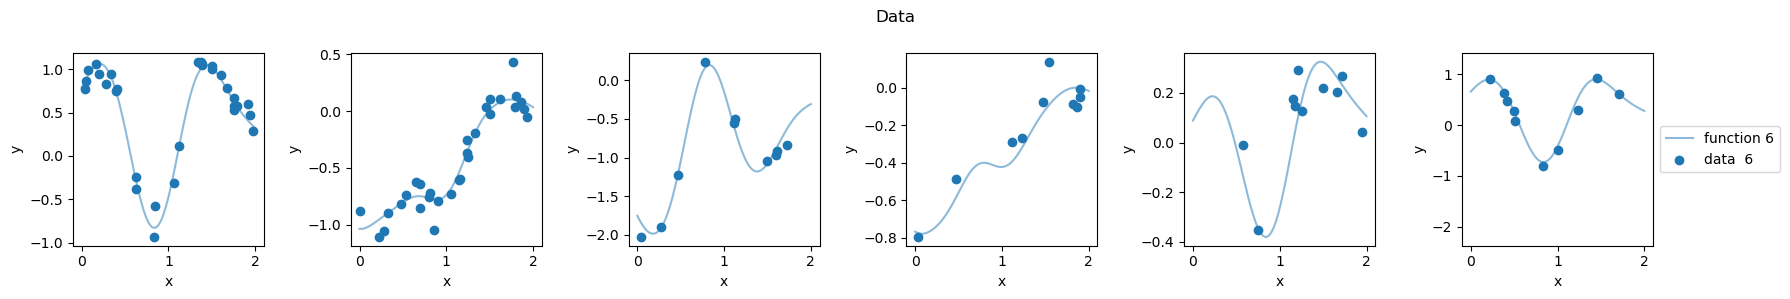

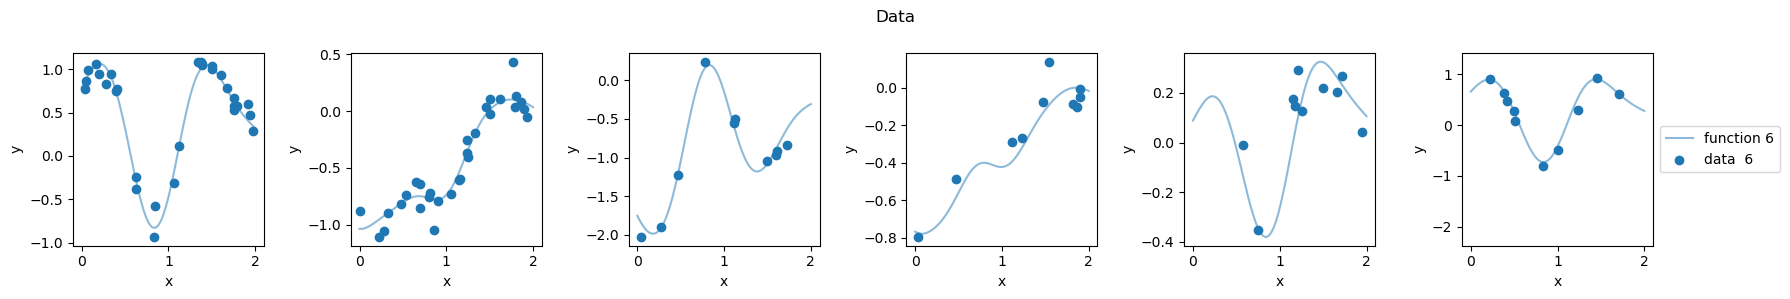

In [70]:
if plot_figs:
    test_fun.plot_data_seperate_plots()

In [71]:
x_new = np.linspace(domain[0], domain[1], 100).reshape(100, 1)
ys_new = []
for fun in test_fun.functions:
    y_new, _ = fun.predict_y(x_new)
    ys_new.append(y_new)

In [72]:
lengthscales_X = [0.1, 0.1][:len(continuous_dims)]
lengthscales = lengthscales_X
X_lmc = np.hstack([data_X, fun_nos])
y = data_y
k = gpflow.kernels.RBF(lengthscales=lengthscales, active_dims=range(observed_dims))
coreg_k = gpflow.kernels.Coregion(output_dim=n_fun, rank=latent_dims ,active_dims=[observed_dims])
cov = k * coreg_k
lmc = gpflow.models.GPR(data=(tf.convert_to_tensor(X_lmc, dtype=default_float()),
                                            tf.convert_to_tensor(y, dtype=default_float())), kernel=cov)
lmc.kernel.kernels[1].W.assign(np.random.uniform(0.1, 1, [n_fun, latent_dims]))
lmc.kernel.kernels[1].kappa.assign([1e-6]*n_fun)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float64, numpy=
array([-13.81551006, -13.81551006, -13.81551006, -13.81551006,
       -13.81551006, -13.81551006])>

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float64, numpy=
array([-13.81551006, -13.81551006, -13.81551006, -13.81551006,
       -13.81551006, -13.81551006])>

Text(0.5, 1.0, 'training curve')

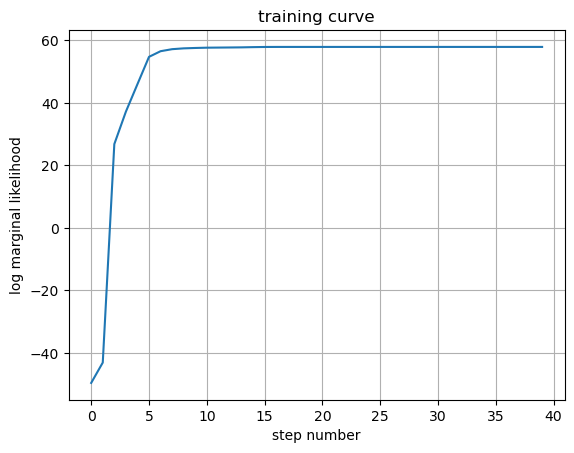

Text(0.5, 1.0, 'training curve')

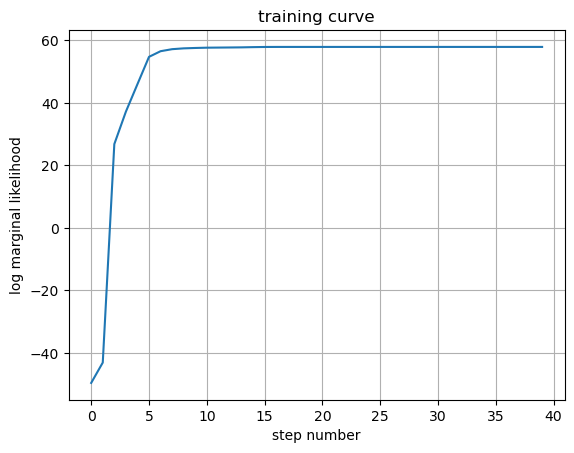

In [73]:
maxiter = 1000

lml = []
def step_callback(step, variables, values):
    lml.append(lmc.log_marginal_likelihood().numpy())
lmc_opt = gpflow.optimizers.Scipy().minimize(
    lmc.training_loss, lmc.trainable_variables, options=dict(maxiter=maxiter), method="L-BFGS-B",
    step_callback=step_callback)

plt.plot(np.arange(len(lml)), np.array(lml))
plt.grid()

plt.xlabel('step number')
plt.ylabel('log marginal likelihood')
plt.title('training curve')

In [74]:
fun_nos_new = np.hstack([[fun_no]*len(x_new) for fun_no in np.unique(fun_nos)])
test = np.vstack([x_new]*n_fun)
x_new_lmc = np.hstack([np.vstack([x_new]*n_fun), fun_nos_new.reshape(len(fun_nos_new), 1)])
lmc_mu, lmc_sig2 = lmc.predict_y(x_new_lmc)

We can see the model fits much better than when it only had 2 points per surface

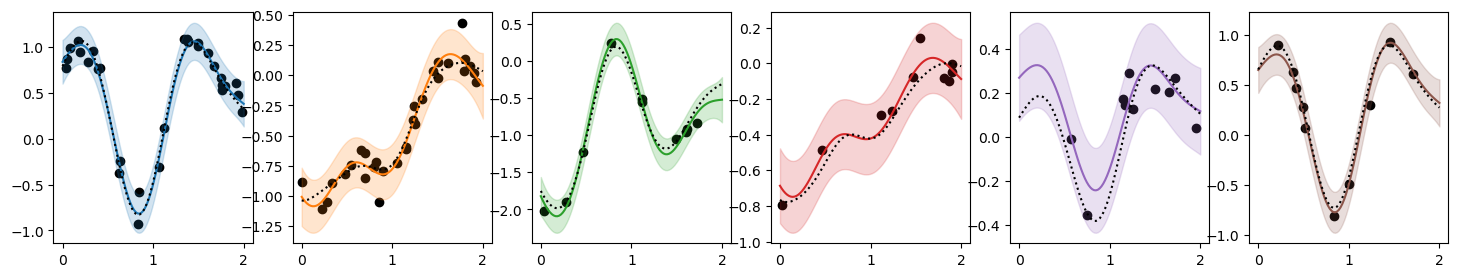

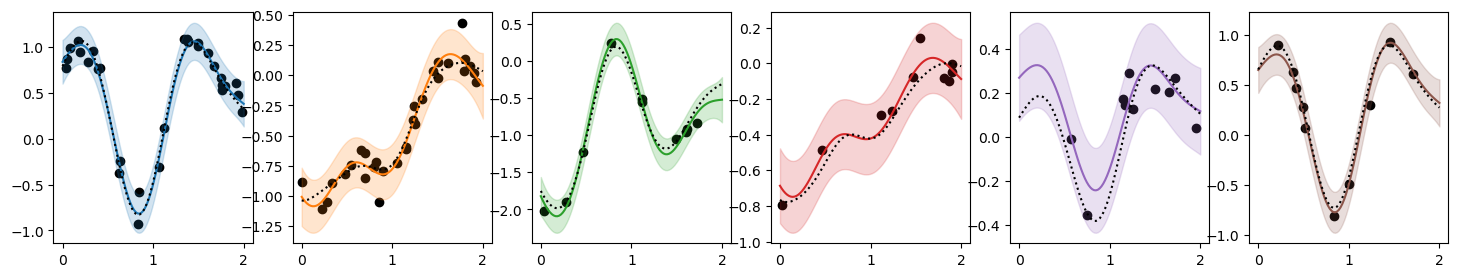

In [75]:
if plot_figs:
    fig, axs = plt.subplots(1, ncols=n_fun, figsize=(3*n_fun, 3))
    ax = axs.flatten()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 100
    for i, fun_no in enumerate(np.unique(fun_nos)):
        idx = np.where(fun_nos_new ==fun_no)[0]
        ax[i].plot(x_new, lmc_mu.numpy()[idx], color=colors[i])
        ax[i].scatter(test_fun.xs[i][:n_points[i]], test_fun.ys[i][:n_points[i]], color='k')
        ax[i].plot(x_new, ys_new[i], linestyle=':', color='k')
        ax[i].fill_between(x_new.flatten(), lmc_mu.numpy()[idx].flatten() + 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()),
                           lmc_mu.numpy()[idx].flatten() - 2*np.sqrt(lmc_sig2.numpy()[idx].flatten()), alpha=0.2, color=colors[i])

The rank of W ends up being 2 which is correct as there are 2 latent functions.

In [76]:
W_lmc = lmc.kernel.kernels[1].W.numpy()
print('rank of W:', np.linalg.matrix_rank(W_lmc))
# B2 = np.dot(W_lmc, W_lmc.T)
# print(np.linalg.matrix_rank(B2))

rank of W: 2
rank of W: 2


The log marginal likeihood of this model:

In [77]:
print('lmc log marginal likelihood',lmc.log_marginal_likelihood())

lmc log marginal likelihood tf.Tensor(57.925066258294436, shape=(), dtype=float64)
lmc log marginal likelihood tf.Tensor(57.925066258294436, shape=(), dtype=float64)


In [78]:
print_summary(lmc)
print(lmc.kernel.kernels[1].kappa.numpy())

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                 │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.39586               │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.37941]             │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────┤
│ GPR.kernel.kernels[1].W         